In [359]:
%matplotlib inline 


from nltk.collocations import *

from gensim.models import word2vec

import pandas as pd
from collections import Counter
import functools
import tqdm
import re
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from itertools import product

from __future__ import division

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import nltk, string
from nltk.tokenize import punkt
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer
import pymorphy2


import xgboost as xgb
from xgboost import XGBClassifier

import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import  roc_auc_score

import matplotlib.pyplot as plt
from hyperopt import hp, tpe, STATUS_OK, Trials, rand
from hyperopt import fmin as fminHyper

from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
exclude = set(punctuation + u'0123456789[]—«»–')
from pymorphy2 import MorphAnalyzer

In [351]:
pd.set_option('display.max_columns', 100)

## Загрузим даные

In [ ]:
dftrain = pd.read_csv('../../data/train_task1_latest_pred.csv', sep=';')
dftest = pd.read_csv('../../data/test_task1_latest_pred.csv', sep=';')

dftrain.drop(['duplication', 'typographical', 'whitespace', 'uncategorized', 'misspelling'], 1, inplace = True)
dftest.drop(['duplication', 'typographical', 'whitespace', 'uncategorized', 'misspelling'], 1, inplace = True)

In [503]:
df1 = dftrain[dftrain['generated_p_3'] == 1].sample(5000).copy()
df2 = dftrain[dftrain['generated_p_6'] == 1].sample(5000).copy()

dftrain.drop(np.append(dftrain[dftrain['generated_p_3'] == 1].index, dftrain[dftrain['generated_p_6'] == 1].index), 0, inplace = True)

dftrain = dftrain.append(df1)
dftrain = dftrain.append(df2)

In [504]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129398 entries, 0 to 155329
Columns: 105 entries, generated_p_3 to question_words_count_relative
dtypes: float64(96), int64(1), object(8)
memory usage: 104.6+ MB


## Xgb all the things

In [505]:
'\', \''.join(dftrain.columns)

"generated_p_3', 'generated_p_6', 'paragraph', 'paragraph_id', 'question', 'question_id', 'target', 'len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection', 'relative_question_len', 'relative_intersection_len', 'relative_intersection_question_len', 'relative_question_idf', 'relative_intersection_idf', 'relative_intersection_question_idf', 'word_idf_paragraph', 'word_idf_question', 'word_idf_intersection', 'paragraph_lemmatized', 'question_lemmatized', 'word2vec_similarity_max', 'word2vec_similarity_min', 'word2vec_similarity_mean', 'word2vec_similarity_std', 'len_intersection_w2v', 'idf_intersection_w2v', 'relative_intersection_len_w2v', 'relative_intersection_question_len_w2v', 'relative_intersection_idf_w2v', 'relative_intersection_question_idf_w2v', 'word_idf_intersection_w2v', 'word_mover_distance', 'word_mover_distance_lemm', 'word_mover_sentence_distance_mean', 'word_mover_sentence_distance_std', 'word_mover_sentence_distance_max',

In [506]:
columns = ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection', 'relative_question_len', 'relative_intersection_len', 'relative_intersection_question_len', 'relative_question_idf', 'relative_intersection_idf', 'relative_intersection_question_idf', 'word_idf_paragraph', 'word_idf_question', 'word_idf_intersection', 'word2vec_similarity_max', 'word2vec_similarity_min', 'word2vec_similarity_mean', 'word2vec_similarity_std', 'len_intersection_w2v', 'idf_intersection_w2v', 'relative_intersection_len_w2v', 'relative_intersection_question_len_w2v', 'relative_intersection_idf_w2v', 'relative_intersection_question_idf_w2v', 'word_idf_intersection_w2v', 'word_mover_distance', 'word_mover_distance_lemm', 'word_mover_sentence_distance_mean', 'word_mover_sentence_distance_std', 'word_mover_sentence_distance_max', 'word_mover_sentence_distance_min', 'word_mover_sentence_distance_split_max', 'word_mover_sentence_distance_split_min', 'word_mover_sentence_distance_split_mean', 'word_mover_sentence_distance_split_std', 'word_mover_sentence_distance_split_lemm_max', 'word_mover_sentence_distance_split_lemm_min', 'word_mover_sentence_distance_split_lemm_mean', 'word_mover_sentence_distance_split_lemm_std', 'len_overlap_relative_paragraph_max', 'len_overlap_relative_question_max', 'idf_overlap_max', 'len_overlap_relative_paragraph_mean', 'len_overlap_relative_question_mean', 'idf_overlap_mean', 'len_overlap_relative_paragraph_std', 'len_overlap_relative_question_std', 'idf_overlap_std', 'similarity_tfid', 'word_mover_distance_prediction', 'word_mover_distance_residuals', 'similarity_tfid_split_max', 'similarity_tfid_split_min', 'similarity_tfid_split_mean', 'similarity_tfid_split_std', 'unique_words_relative_to_question', 'word_ocurences_mean', 'word_ocurences_std', 'word_ocurences_max', 'word_ocurences_max_relative_to_question', 'similarity_pattern_mean', 'similarity_pattern_std', 'similarity_pattern_max', 'similarity_pattern_min', 'word_mover_distance_residuals', 'similarity_residuals_tfid', 'word_mover_distance_residuals_prediction', 'question_words_in_paragraph_relative', 'similarity_all_mean', 'similarity_tfid_relative_split', 'similarity_tfid_relative_pattern', 'word_mover_distance_all_mean', 'word_mover_distance_all_mean_all', 'word_mover_distance_relative_sentence', 'word_mover_distance_relative_sentence_split', 'word_mover_distance_residuals_relative_paragraph', 'question_words_in_prediction_sentence_words_relative', 'question_words_count_relative']
columns = list(set(columns))

In [507]:
dftrain = dftrain.replace([np.inf, -np.inf], np.nan)
dftrain.fillna(0, inplace = True)
dftest = dftest.replace([np.inf, -np.inf], np.nan)
dftest.fillna(0, inplace = True)

test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(dftrain[columns], dftrain['target'], test_size = test_size, random_state = random_state)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [471]:
def score(params):
    print("Training with params:")
    print(params)
    
    num_round = int(params['n_estimators'])    
    del params['n_estimators']
    params['max_depth'] = (int) (params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid)
    score = roc_auc_score(y_test, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [472]:
def optimize(trials):

    space = {
        'n_estimators' : 150,
        'eta' : hp.quniform('eta', 0.1, 0.5, 0.1),
        'max_depth' : hp.quniform('max_depth', 4, 10, 2),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
        'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
#         'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1, 0.25),
#         'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.5),
#         'reg_lambda' : hp.quniform('reg_lambda', 0, 1, 0.5),
        'eval_metric': 'auc',
        'objective': 'binary:logistic', 
        'nthread' : 4,
        'silent' : 1
    }
    
    best = fminHyper(score, space, algo=tpe.suggest, trials=trials, max_evals=75)
    print(best)

In [473]:
%%time
trials = Trials()
optimize(trials)

Training with params:
{'max_depth': 6.0, 'eval_metric': 'auc', 'min_child_weight': 3.0, 'objective': 'binary:logistic', 'eta': 0.2, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9870212952853599


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 4.0, 'objective': 'binary:logistic', 'eta': 0.4, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.75}
	Score 0.9863746524011363


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 3.0, 'objective': 'binary:logistic', 'eta': 0.1, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9872601665611511


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 4.0, 'objective': 'binary:logistic', 'eta': 0.2, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9864923467

	Score 0.9832882739187939


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 1.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 1.0, 'subsample': 0.5}
	Score 0.9832882739187939


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 1.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 1.0, 'subsample': 0.5}
	Score 0.9832882739187939


Training with params:
{'max_depth': 8.0, 'eval_metric': 'auc', 'min_child_weight': 2.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 1.0, 'subsample': 0.5}
	Score 0.9831317728663124


Training with params:
{'max_depth': 10.0, 'eval_metric': 'auc', 'min_child_weight': 2.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 1.0, 'subsample': 

	Score 0.9828179617116131


Training with params:
{'max_depth': 6.0, 'eval_metric': 'auc', 'min_child_weight': 4.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9828179617116131


Training with params:
{'max_depth': 6.0, 'eval_metric': 'auc', 'min_child_weight': 4.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9828179617116131


Training with params:
{'max_depth': 6.0, 'eval_metric': 'auc', 'min_child_weight': 3.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample': 0.5}
	Score 0.9834179208448508


Training with params:
{'max_depth': 4.0, 'eval_metric': 'auc', 'min_child_weight': 5.0, 'objective': 'binary:logistic', 'eta': 0.5, 'silent': 1, 'nthread': 4, 'n_estimators': 150, 'colsample_bytree': 0.75, 'subsample

In [510]:
params = {'min_child_weight': 2.0, 'max_depth': 10.0, 'colsample_bytree': 0.75, 'subsample': 0.75, 'eta': 0.1}
params['objective'] = 'binary:logistic'
# params['eta'] = 0.1
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = 'auc'

**Смотрим на точность**

In [495]:
# прогоняем на кросс-валидации с метрикой merror
trees = 1000
cv = xgb.cv(params, dtrain, metrics = ('auc'), nfold = 5, num_boost_round=trees, early_stopping_rounds = 15, verbose_eval=True)

[0]	train-auc:0.978705+0.000476192	test-auc:0.97471+0.000964882
[1]	train-auc:0.983738+0.000575124	test-auc:0.979425+0.00095146
[2]	train-auc:0.986029+0.000279027	test-auc:0.981676+0.000431653
[3]	train-auc:0.987425+0.000209204	test-auc:0.982696+0.000288035
[4]	train-auc:0.98836+0.00013411	test-auc:0.983406+0.000237329
[5]	train-auc:0.989022+0.000159102	test-auc:0.983805+0.000212088
[6]	train-auc:0.989684+0.000172925	test-auc:0.984311+0.000329832
[7]	train-auc:0.99014+0.000121013	test-auc:0.984716+0.0003731
[8]	train-auc:0.990652+8.81512e-05	test-auc:0.985147+0.000325326
[9]	train-auc:0.991002+0.000124821	test-auc:0.985397+0.000320666
[10]	train-auc:0.991304+0.000113456	test-auc:0.985651+0.000403577
[11]	train-auc:0.991584+0.000118038	test-auc:0.985813+0.000424941
[12]	train-auc:0.991916+0.000153956	test-auc:0.98597+0.000371863
[13]	train-auc:0.992223+0.000151727	test-auc:0.986081+0.00035051
[14]	train-auc:0.992456+9.0214e-05	test-auc:0.986162+0.000344302
[15]	train-auc:0.992685+0.0001

KeyboardInterrupt: 

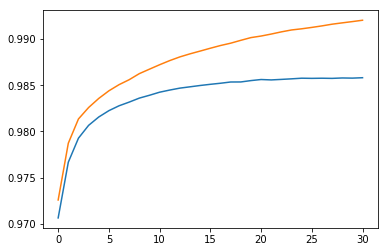

In [488]:
plt.plot(range(cv.shape[0]), cv['test-auc-mean'])
plt.plot(range(cv.shape[0]), cv['train-auc-mean'])

In [489]:
num_boost_round=cv['test-auc-mean'].argmax()
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

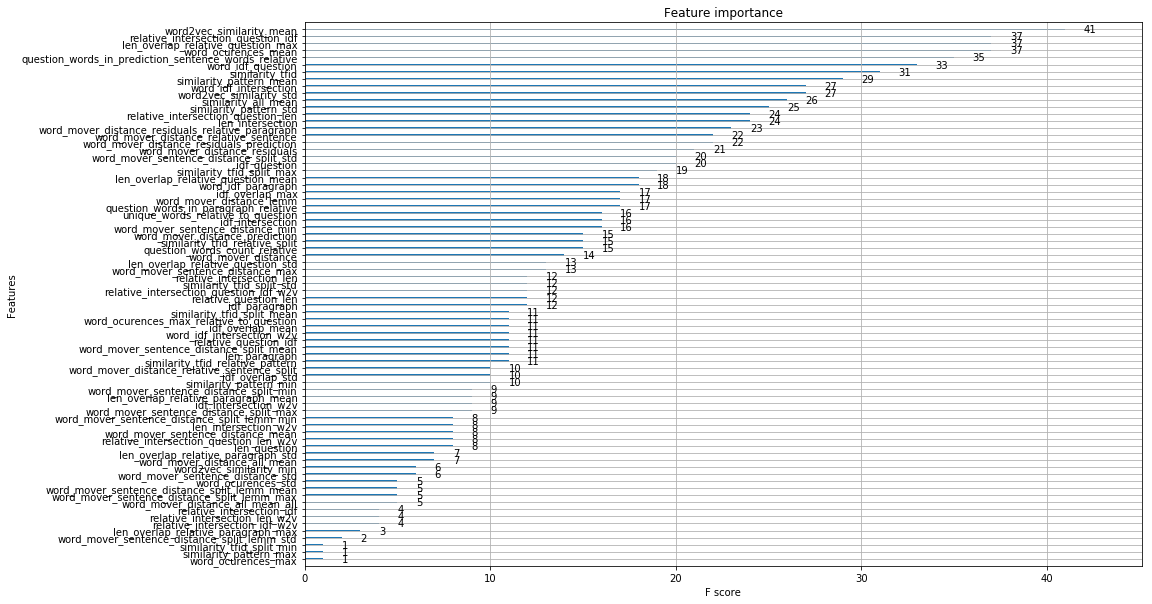

In [490]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(booster=bst, ax=ax)

In [491]:
xpredictions = bst.predict(dvalid)
score = roc_auc_score(dvalid.get_label(), xpredictions)
print('xgb - roc_auc_score: ' + str(score))

xgb - roc_auc_score: 0.985144086435


In [480]:
a = []
for i in range(0, 3):
    params_i = params
    params_i['colsample_bylevel'] = 0.5 + i * 0.25
    params_i['colsample_bytree'] = 0.5 + i * 0.25
    a.append(xgb.train(params_i, dtrain, num_boost_round=num_boost_round).predict(dvalid))

KeyboardInterrupt: 

In [ ]:
data = a
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)
print('e - roc_auc_score: ' + str(score))

In [ ]:
xpredictions = epredictions

## Обучим на всех данных

In [ ]:
# полные данные
dtrainfull = xgb.DMatrix(dftrain[columns], dftrain['target'])

# прогоняем на кросс-валидации с метрикой merror
trees = 1000
cv = xgb.cv(params, dtrainfull, metrics = ('auc'), nfold=5, num_boost_round=trees, early_stopping_rounds=50, verbose_eval=False)

# triple xgb
a = []
for i in range(0, 3):
    params_i = params
#     params_i['colsample_bylevel'] = 0.5 + i * 0.25
    params_i['colsample_bytree'] = 0.5 + i * 0.25
    a.append(xgb.train(params, dtrainfull, num_boost_round=num_boost_round).predict(xgb.DMatrix(dftest[columns])))   
    
# save
dfsave = dftest.copy()
data = [a[0], a[1], a[2]]#, xgb_c_predictions, rfcpredictions]
epredictions = [sum(e)/len(e) for e in zip(*data)]
dfsave['prediction'] = epredictions
dfsave[['paragraph_id', 'question_id', 'prediction']].to_csv("../../results/taskA_prediction_1.csv", index=False)

**Смотрим на результаты**

In [457]:
pd.options.display.max_colwidth = 10000

In [460]:
dfsave[['paragraph', 'question', 'prediction', 'question_residuals']][dfsave['prediction'] > 0.5].sample(50)

,paragraph,question,prediction,question_residuals
52961,"В Концепции человека у Маркса Эрих Фромм подчёркивал, что отчуждение труда в современном производстве куда сильнее, чем во времена ремесленничества и мануфактуры, где человек сам использует орудия труда. В традиционных обществах, отмечал Маркс, работа нередко была изнурительной, но люди могли сами организовывать свою работу, для выполнения которой требовалось множество знаний и навыков. Наёмные же рабочие в промышленности практически никак не влияют на характер выполняемых заданий, внося лишь небольшую часть в процесс изготовления целого продукта, и совсем не могут повлиять на то, кому и как он, в конце концов, продаётся. Работа, таким образом, становится чем-то чуждым, заданием, которое рабочий должен выполнить, чтобы получить вознаграждение, но которое, по сути своей, его совершенно не привлекает.","Кто мы, собравшиеся тут, в сути политических процессов изготовления целого продукта, и отчуждение труда?",0.782315,собраться политический
47903,"Фредерик Брукс и Ч. Э. Р. Хоар делают акцент на необходимости обеспечения концептуальной целостности информационных систем вообще и языков программирования в частности, чтобы в каждой части системы использовались сходные синтаксические и семантические формы и не требовалось осваивать помимо собственно состава системы также и правила её идиоматического использования. Хоар предсказывал, что сложность Ады станет причиной катастроф. Алан Кэй отделяет языки, являющиеся стилем во плоти (англ. crystalization of style) от прочих языков, являющихся склеиванием возможностей (англ. agglutination of features). Грег Нельсон и Эндрю Аппель выделяют в особую категорию языки, наследованные от математики (англ. mathematically-derived languages).",На какой необходимости делают акцент Фредерик Брукс и Ч. Э. Р. Хоар?,0.810367,0
42899,"Крупные представители подсемейства скарабеинов могут являться промежуточными хозяевами ряда гельминтов, в том числе патогенных для домашних животных и иногда человека. В Южной Индии и Шри-Ланке существует ещё одна паразитологическая проблема, связанная с представителями подсемейства скарабеинов. Среди местного населения иногда возникает периодическая болезнь кишечника, сопровождающаяся кровавой диареей, получившая название скарабиаз . Она вызывается некоторыми мелкими видами Onthaphagus. Эти жуки во время сна проникают в кишечник человека через задний проход, особенно детей, живущих в антисанитарных условиях, и вызывают повреждение слизистой оболочки кишечника.","Как называется периодическая болезнь кишечника, сопровождающаяся кровавой диареей?",0.942889,называться
32044,"Дарвин оставался в Кембридже до июня. Он изучает труд Пэйли Естественная Теология (англ. Natural Theology ), в котором автор приводит теологические аргументы для объяснения природы естества, объясняя адаптацию как воздействие Бога посредством законов природы. Он читает новую книгу Гершеля, которая описывает высочайшую цель естественной философии как постижение законов через индуктивные рассуждения, основанные на наблюдениях. Также особое внимание он уделяет книге Александра фон Гумбольдта Личное повествование (англ. Personal Narrative ), в которой автор описывает свои путешествия. Описания острова Тенерифе, которые приводит Гумбольдт, заражают Дарвина и его друзей идеей отправиться туда, по завершении обучения, для занятий естественной историей в условиях тропиков. Для подготовки к этому он обучается на курсе геологии преподобного Адама Седжвика, а после отправляется с ним летом на картографирование пород в Уэльсе. Через две недели, вернувшись после непродолжительной геологической поездки по Северному Уэльсу, он находит письмо от Генслоу, в котором тот рекомендовал Дарвина как подходящего человека на неоплачиваемую должность натуралиста капитану Бигля , Роберту Фицрою, под чьим командованием через четыре недели должна начаться экспедиция к берегам Южной Америки. Дарвин готов был тут же принять предложение, однако его отец возражал против такого рода при